In [12]:
# =============================================================================
# CONFIGURACIÓ I IMPORTS
# =============================================================================

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, brier_score_loss,
    confusion_matrix, classification_report, precision_score, recall_score,
    roc_curve
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import xgboost as xgb

# Configuració de paths
DATA_RAW = Path("data/raw")
DATA_PROCESSED = Path("data/processed")
NOTEBOOKS = Path("notebooks")
SCRIPTS = Path("scripts")
MODELS = Path("models")
REPORTS = Path("reports")
CONFIG = Path("config")
FIG_DIR = Path("figures")

# Path del fitxer CSV dins data/raw
DATA_PATH = DATA_RAW / "alzheimers_disease_data.csv"

# Crear directoris
for p in [FIG_DIR, DATA_RAW, DATA_PROCESSED, NOTEBOOKS, SCRIPTS, MODELS, REPORTS, CONFIG]:
    p.mkdir(parents=True, exist_ok=True)

print("Carpetes creades i DATA_PATH:", DATA_PATH)

# Configuració general
RANDOM_STATE = 42
pd.set_option("display.max_columns", 200)



Carpetes creades i DATA_PATH: data\raw\alzheimers_disease_data.csv


In [13]:
# =============================================================================
# 1. CARREGA I EXPLORACIÓ INICIAL DE DADES
# =============================================================================

print("=== CARREGA I EXPLORACIÓ INICIAL ===")
df = pd.read_csv(DATA_PATH)
print("Shape del dataset:", df.shape)
print("\nPrimeres files:")
display(df.head())
print("\nInformació del dataset:")
display(df.info())

target_col = "Diagnosis"

print(f"\nDistribució de la variable objectiu '{target_col}':")
print(df[target_col].value_counts(dropna=False))
print(f"Prevalença (casos positius/total): {df[target_col].mean():.3f}")



=== CARREGA I EXPLORACIÓ INICIAL ===
Shape del dataset: (2149, 35)

Primeres files:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryAlzheimers,CardiovascularDisease,Diabetes,Depression,HeadInjury,Hypertension,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,0,0,1,1,0,0,142,72,242.366840,56.150897,33.682563,162.189143,21.463532,6.518877,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,0,0,0,0,0,0,115,64,231.162595,193.407996,79.028477,294.630909,20.613267,7.118696,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,1,0,0,0,0,0,99,116,284.181858,153.322762,69.772292,83.638324,7.356249,5.895077,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,0,0,0,0,0,0,118,115,159.582240,65.366637,68.457491,277.577358,13.991127,8.965106,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,0,0,0,0,0,0,94,117,237.602184,92.869700,56.874305,291.198780,13.517609,6.045039,0,0,0.014691,0,0,1,1,0,0,XXXConfid



Informació del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes               

None


Distribució de la variable objectiu 'Diagnosis':
Diagnosis
0    1389
1     760
Name: count, dtype: int64
Prevalença (casos positius/total): 0.354



=== ANÀLISI EXPLORATORI ===


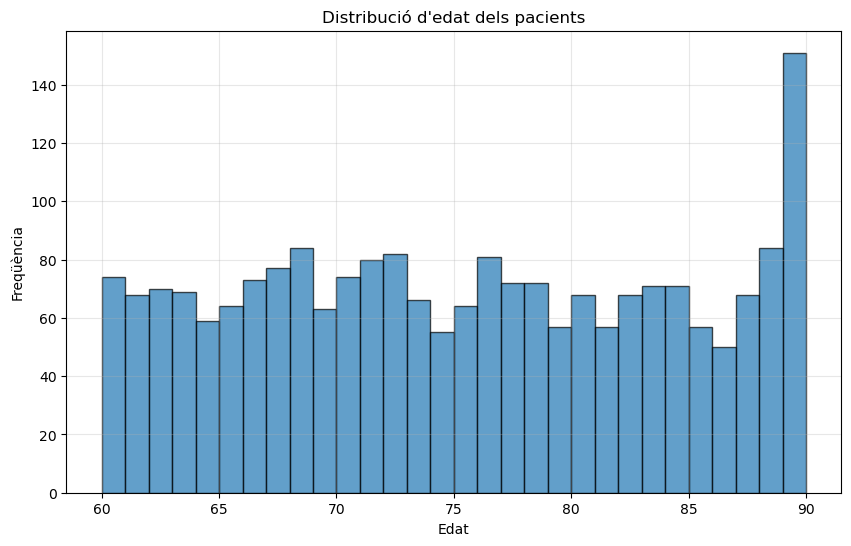

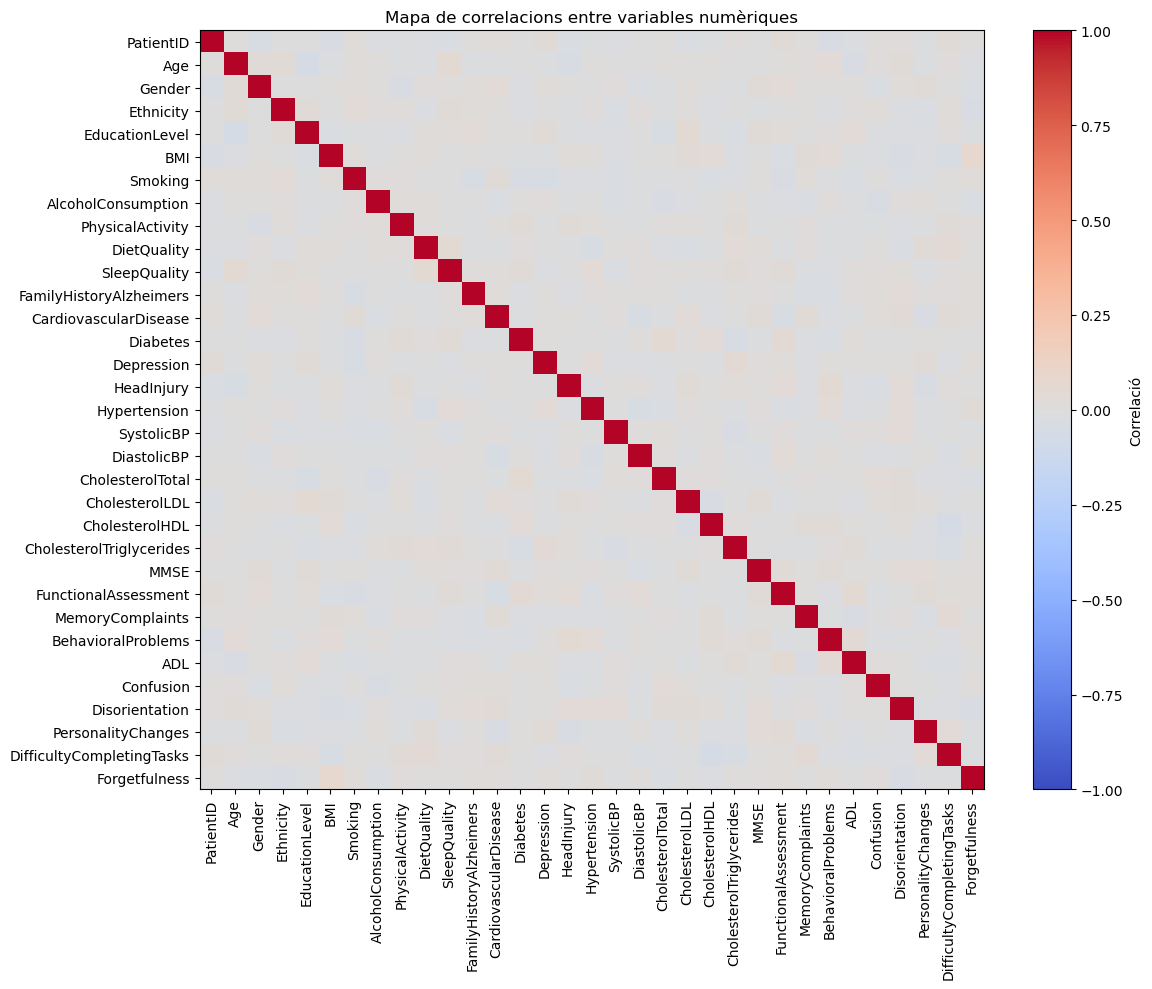


Comparació de variables per diagnòstic:
ADL: {0: 5.707951396076797, 1: 3.6579383023673033}
MemoryComplaints: {0: 0.11591072714182865, 1: 0.3763157894736842}
Confusion: {0: 0.210943124550036, 1: 0.19473684210526315}
Disorientation: {0: 0.16486681065514758, 1: 0.14605263157894738}
Forgetfulness: {0: 0.30165586753059753, 1: 0.3013157894736842}


In [14]:
# =============================================================================
# 2. ANÀLISI EXPLORATORI DE DADES (EDA)
# =============================================================================

print("\n=== ANÀLISI EXPLORATORI ===")

# Distribució d'edat
plt.figure(figsize=(10, 6))
plt.hist(df['Age'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribució d\'edat dels pacients')
plt.xlabel('Edat')
plt.ylabel('Freqüència')
plt.grid(True, alpha=0.3)
plt.savefig(FIG_DIR / "age_hist.png", bbox_inches='tight', dpi=300)
plt.show()

# Taula de correlacions
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

corr = df[num_cols].corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlació')
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Mapa de correlacions entre variables numèriques")
plt.tight_layout()
plt.savefig(FIG_DIR / "corr_matrix.png", bbox_inches='tight', dpi=300)
plt.show()

# Comparació de mitjanes per Diagnosis
print("\nComparació de variables per diagnòstic:")
cols_to_check = ['ADL', 'MemoryComplaints', 'Confusion', 'Disorientation', 'Forgetfulness']
for c in cols_to_check:
    if c in df.columns:
        means = df.groupby(target_col)[c].mean()
        print(f"{c}: {means.to_dict()}")



In [15]:
# =============================================================================
# 3. NETEJA I PREPROCESSAT DE DADES
# =============================================================================

print("\n=== NETEJA I PREPROCESSAT ===")

df_clean = df.copy()

# Eliminació de variables no predictives
columns_to_drop = ['PatientID', 'DoctorInCharge']
df_clean = df_clean.drop(columns=[col for col in columns_to_drop if col in df_clean.columns], errors='ignore')
print(f"Variables eliminades: {columns_to_drop}")

# Anàlisi de valors missing
print("\nAnàlisi de valors missing:")
missing = df_clean.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df_clean)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
display(missing_df[missing_df['Missing'] > 0])

# Variables numèriques contínues (valors amb rang ampli)
continuous_numeric = ['Age', 'BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 
                     'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 
                     'MMSE', 'FunctionalAssessment', 'ADL', 'AlcoholConsumption', 
                     'PhysicalActivity', 'DietQuality', 'SleepQuality']

# Variables binàries (0/1) - les hem de tractar com a categòriques
binary_vars = ['Gender', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 
               'BehavioralProblems', 'Confusion', 'Disorientation', 'PersonalityChanges', 
               'DifficultyCompletingTasks', 'Forgetfulness']

# Variables categòriques amb múltiples categories
multi_category_vars = ['Ethnicity', 'EducationLevel']

# Filtrar només les que existeixen al dataset
continuous_numeric = [c for c in continuous_numeric if c in df_clean.columns]
binary_vars = [c for c in binary_vars if c in df_clean.columns]
multi_category_vars = [c for c in multi_category_vars if c in df_clean.columns]

print(f"\nVariables numèriques contínues ({len(continuous_numeric)}): {continuous_numeric}")
print(f"Variables binàries ({len(binary_vars)}): {binary_vars}")
print(f"Variables categòriques múltiples ({len(multi_category_vars)}): {multi_category_vars}")

# Imputació de valors missing 
print("\nImputant valors missing...")

# Per variables numèriques contínues: mediana
for c in continuous_numeric:
    if c in df_clean.columns and df_clean[c].isnull().any():
        median_val = df_clean[c].median()
        df_clean[c].fillna(median_val, inplace=True)
        print(f"  {c}: imputat amb mediana ({median_val:.2f})")

# Per variables binàries: moda (majoria)
for c in binary_vars:
    if c in df_clean.columns and df_clean[c].isnull().any():
        mode_val = df_clean[c].mode().iloc[0] if not df_clean[c].mode().empty else 0
        df_clean[c].fillna(mode_val, inplace=True)
        print(f"  {c}: imputat amb moda ({mode_val})")

# Per variables categòriques múltiples: moda
for c in multi_category_vars:
    if c in df_clean.columns and df_clean[c].isnull().any():
        mode_val = df_clean[c].mode().iloc[0] if not df_clean[c].mode().empty else "Desconegut"
        df_clean[c].fillna(mode_val, inplace=True)
        print(f"  {c}: imputat amb moda ('{mode_val}')")

print(f"\nValors missing després de la imputació: {df_clean.isnull().sum().sum()}")




=== NETEJA I PREPROCESSAT ===
Variables eliminades: ['PatientID', 'DoctorInCharge']

Anàlisi de valors missing:


,Missing,Percent



Variables numèriques contínues (15): ['Age', 'BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality']
Variables binàries (15): ['Gender', 'Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']
Variables categòriques múltiples (2): ['Ethnicity', 'EducationLevel']

Imputant valors missing...

Valors missing després de la imputació: 0


In [16]:
# =============================================================================
# 4. ENGINYERIA DE CARACTERÍSTIQUES
# =============================================================================

print("\n=== ENGINYERIA DE CARACTERÍSTIQUES ===")

# Convertir variables binàries a categòriques
print("Convertint variables binàries a categòriques...")
for col in binary_vars:
    if col in df_clean.columns:
        # Convertir 0/1 a 'No'/'Yes' per a les variables booleanes
        if col in ['Smoking', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 
                  'Depression', 'HeadInjury', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems', 
                  'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']:
            df_clean[col] = df_clean[col].map({0: 'No', 1: 'Yes'})
            df_clean[col] = pd.Categorical(df_clean[col], categories=['No', 'Yes'], ordered=False)
        # Gender és especial
        elif col == 'Gender':
            unique_vals = df_clean[col].unique()
            print(f"  Gender valors únics: {unique_vals}")
            if set(unique_vals).issubset({0, 1}):
                df_clean[col] = df_clean[col].map({0: 'Male', 1: 'Female'})
            df_clean[col] = pd.Categorical(df_clean[col], categories=['Male', 'Female'], ordered=False)
        print(f"  {col}: convertit a categòrica")

# Convertir variables categòriques múltiples
print("\nConvertint variables categòriques múltiples...")
for col in multi_category_vars:
    if col in df_clean.columns:
        # Ethnicity
        if col == 'Ethnicity':
            unique_vals = df_clean[col].unique()
            print(f"  Ethnicity valors únics: {unique_vals}")
            if set(unique_vals).issubset({0, 1, 2, 3}):
                ethnicity_map = {0: 'Caucasian', 1: 'African American', 2: 'Asian', 3: 'Other'}
                df_clean[col] = df_clean[col].map(ethnicity_map)
            df_clean[col] = pd.Categorical(df_clean[col], 
                                         categories=['Caucasian', 'African American', 'Asian', 'Other'], 
                                         ordered=False)
        # EducationLevel
        elif col == 'EducationLevel':
            unique_vals = df_clean[col].unique()
            print(f"  EducationLevel valors únics: {unique_vals}")
            if set(unique_vals).issubset({0, 1, 2, 3}):
                education_map = {0: 'None', 1: 'High School', 2: "Bachelor's", 3: 'Higher'}
                df_clean[col] = df_clean[col].map(education_map)
            df_clean[col] = pd.Categorical(df_clean[col], 
                                         categories=['None', 'High School', "Bachelor's", 'Higher'], 
                                         ordered=False)
        print(f"  {col}: convertit a categòrica")

# Creació de grups d'edat
print("\nCreant grups d'edat...")
df_clean['Age_group'] = pd.cut(
    df_clean['Age'],
    bins=[0, 64, 74, 84, 120],
    labels=['<65', '65-74', '75-84', '85+']
)
df_clean['Age_group'] = pd.Categorical(df_clean['Age_group'],
                                     categories=['<65', '65-74', '75-84', '85+'],
                                     ordered=True)
print("  Age_group: creat amb èxit")

# Processament de BMI
print("\nProcessant BMI...")
df_clean['BMI_clipped'] = df_clean['BMI'].clip(lower=10, upper=60)
print(f"  BMI: valors recortats entre 10 i 60")

# Llista final de variables
cat_features = binary_vars + multi_category_vars + ['Age_group']
cat_features = [c for c in cat_features if c in df_clean.columns]
numeric_features = continuous_numeric + ['BMI_clipped']
numeric_features = [c for c in numeric_features if c in df_clean.columns]

print(f"\nVariables categòriques finals: {len(cat_features)}")
print(f"Variables numèriques contínues finals: {len(numeric_features)}")

# =============================================================================
# 4.5. DEFINIR CUSTOM_LABELS
# =============================================================================

print("\n=== DEFININT ETIQUETES PERSONALITZADES ===")

custom_labels = {}

# Per a variables binàries
for col in binary_vars:
    if col in df_clean.columns:
        if col == 'Gender':
            custom_labels[col] = ['Male', 'Female']
        else:
            custom_labels[col] = ['No', 'Yes']

# Per a variables categòriques múltiples
for col in multi_category_vars:
    if col in df_clean.columns:
        if col == 'Ethnicity':
            custom_labels[col] = ['Caucasian', 'African American', 'Asian', 'Other']
        elif col == 'EducationLevel':
            custom_labels[col] = ['None', 'High School', "Bachelor's", 'Higher']

# Per a Age_group
custom_labels['Age_group'] = ['<65', '65-74', '75-84', '85+']

print("Diccionari custom_labels creat amb èxit")




=== ENGINYERIA DE CARACTERÍSTIQUES ===
Convertint variables binàries a categòriques...
  Gender valors únics: [0 1]
  Gender: convertit a categòrica
  Smoking: convertit a categòrica
  FamilyHistoryAlzheimers: convertit a categòrica
  CardiovascularDisease: convertit a categòrica
  Diabetes: convertit a categòrica
  Depression: convertit a categòrica
  HeadInjury: convertit a categòrica
  Hypertension: convertit a categòrica
  MemoryComplaints: convertit a categòrica
  BehavioralProblems: convertit a categòrica
  Confusion: convertit a categòrica
  Disorientation: convertit a categòrica
  PersonalityChanges: convertit a categòrica
  DifficultyCompletingTasks: convertit a categòrica
  Forgetfulness: convertit a categòrica

Convertint variables categòriques múltiples...
  Ethnicity valors únics: [0 3 1 2]
  Ethnicity: convertit a categòrica
  EducationLevel valors únics: [2 0 1 3]
  EducationLevel: convertit a categòrica

Creant grups d'edat...
  Age_group: creat amb èxit

Processant BM

In [17]:
# =============================================================================
# 5. PREPARACIÓ DE DADES PER MODELATGE
# =============================================================================

print("\n=== PREPARACIÓ PER MODELATGE ===")

# Separació de features i target
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

print(f"Dimensions: X={X.shape}, y={y.shape}")

# Split estratificat de dades
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=RANDOM_STATE
)

print("Divisió de dades completada:")
print(f"  Entrenament: {X_train.shape[0]} mostres ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validació: {X_val.shape[0]} mostres ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]} mostres ({X_test.shape[0]/len(X)*100:.1f}%)")

# Identificació de columnes per al preprocessat
numeric_cols = [c for c in numeric_features if c in X_train.columns]
categorical_cols = [c for c in cat_features if c in X_train.columns]

print(f"\nVariables per al preprocessat:")
print(f"  Numèriques contínues: {len(numeric_cols)} variables")
print(f"  Categòriques: {len(categorical_cols)} variables")

# Categories per OneHotEncoder
ohe_categories = [
    custom_labels[c] if c in custom_labels else X_train[c].cat.categories.tolist()
    for c in categorical_cols
]

# Pipeline de preprocessat
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(
        categories=ohe_categories,
        handle_unknown='ignore'
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ], remainder='drop'
)

print("Preprocessador configurat correctament")


=== PREPARACIÓ PER MODELATGE ===
Dimensions: X=(2149, 34), y=(2149,)
Divisió de dades completada:
  Entrenament: 1289 mostres (60.0%)
  Validació: 430 mostres (20.0%)
  Test: 430 mostres (20.0%)

Variables per al preprocessat:
  Numèriques contínues: 16 variables
  Categòriques: 18 variables
Preprocessador configurat correctament


In [18]:
# =============================================================================
# 6. DEFINICIÓ I ENTRENAMENT DE MODELS
# =============================================================================

print("\n=== DEFINICIÓ DE MODELS ===")

# Model de Regressió Logística
pipe_log = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced', 
        random_state=RANDOM_STATE
    ))
])

# Model Random Forest
pipe_rf = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced', 
        random_state=RANDOM_STATE, 
        n_jobs=-1
    ))
])

# Model XGBoost
pipe_xgb = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss', 
        random_state=RANDOM_STATE
    ))
])

models = {
    'Regressió Logística': pipe_log,
    'Random Forest': pipe_rf,
    'XGBoost': pipe_xgb
}

print("Entrenant models...")
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"  {name}: entrenat")




=== DEFINICIÓ DE MODELS ===
Entrenant models...
  Regressió Logística: entrenat
  Random Forest: entrenat
  XGBoost: entrenat


c:\Users\cargo\anaconda3\envs\ia-bio\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:35:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
# =============================================================================
# 7. FUNCIONS D'AVALUACIÓ
# =============================================================================

def evaluate_probs(model, X, y, prefix="test"):
    """Avaluació completa d'un model amb múltiples mètriques"""
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)
    
    roc = roc_auc_score(y, probs)
    precision, recall, _ = precision_recall_curve(y, probs)
    pr_auc = auc(recall, precision)
    brier = brier_score_loss(y, probs)
    cm = confusion_matrix(y, preds)
    report = classification_report(y, preds, output_dict=True)
    
    out = {
        'roc_auc': roc,
        'pr_auc': pr_auc,
        'brier': brier,
        'confusion_matrix': cm,
        'classification_report': report,
        'probs': probs
    }
    
    print(f"{prefix} -> ROC-AUC: {roc:.4f} | PR-AUC: {pr_auc:.4f} | Brier: {brier:.4f}")
    return out

def plot_roc_curves(results_dict, y_true, title="Corbes ROC"):
    """Visualització de corbes ROC comparatives"""
    plt.figure(figsize=(10, 8))
    
    for name, results in results_dict.items():
        fpr, tpr, _ = roc_curve(y_true, results['probs'])
        plt.plot(fpr, tpr, lw=2.5, label=f'{name} (AUC = {results["roc_auc"]:.3f})')
    
    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positius', fontsize=12)
    plt.ylabel('Taxa de Cert Positius', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "roc_curves_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()

def plot_pr_curves(results_dict, y_true, title="Corbes Precision-Recall"):
    """Visualització de corbes Precision-Recall comparatives"""
    plt.figure(figsize=(10, 8))
    
    for name, results in results_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, results['probs'])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, lw=2.5, label=f'{name} (AUC = {pr_auc:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / "pr_curves_comparison.png", bbox_inches='tight', dpi=300)
    plt.show()

def plot_calibration_curve(model, X, y, label):
    """Visualització de corbes de calibració"""
    prob_pos = model.predict_proba(X)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y, prob_pos, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", linewidth=2, markersize=6, label=label)
    plt.plot([0, 1], [0, 1], "--", color='gray', label="Calibració perfecta")
    plt.xlabel("Probabilitat predita mitjana", fontsize=12)
    plt.ylabel("Fracció de positius", fontsize=12)
    plt.title(f"Corba de Calibració - {label}", fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"calibration_{label.replace(' ','_')}.png", bbox_inches='tight', dpi=300)
    plt.show()




=== AVALUACIÓ INICIAL EN VALIDACIÓ ===
Regressió Logística_val -> ROC-AUC: 0.9037 | PR-AUC: 0.8571 | Brier: 0.1173
Random Forest_val -> ROC-AUC: 0.9571 | PR-AUC: 0.9387 | Brier: 0.0873
XGBoost_val -> ROC-AUC: 0.9629 | PR-AUC: 0.9517 | Brier: 0.0492


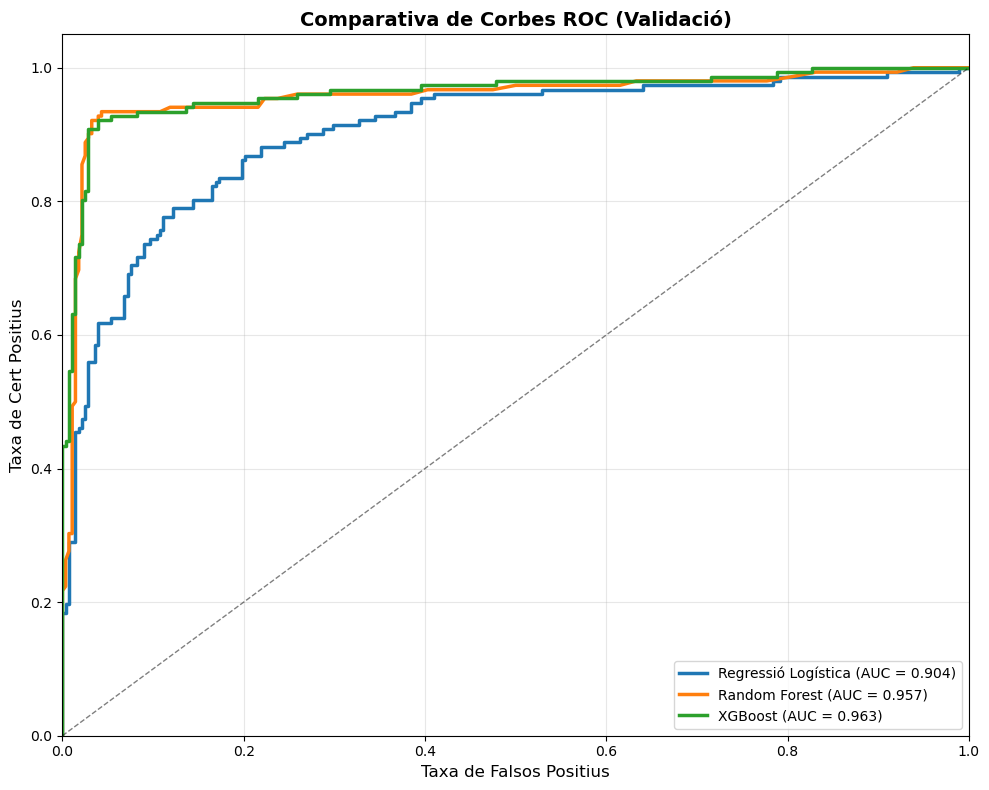

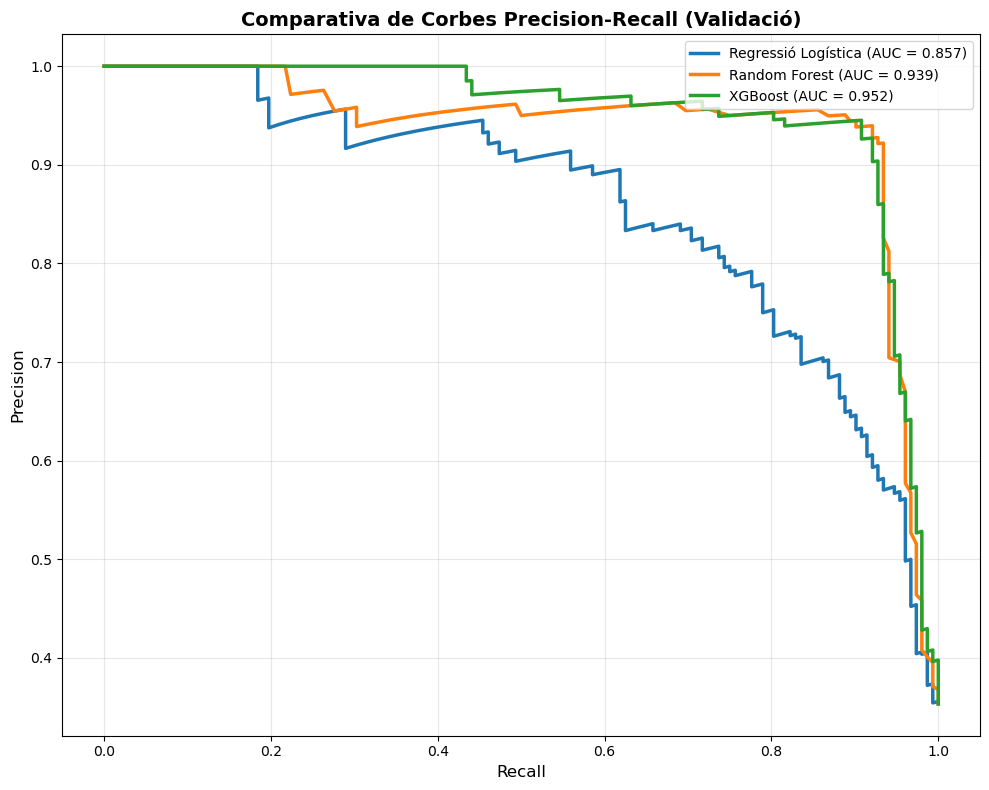

In [20]:
# =============================================================================
# 8. AVALUACIÓ INICIAL DE MODELS
# =============================================================================

print("\n=== AVALUACIÓ INICIAL EN VALIDACIÓ ===")

results_val = {}
for name, model in models.items():
    results_val[name] = evaluate_probs(model, X_val, y_val, prefix=f"{name}_val")

# Visualitzacions comparatives
plot_roc_curves(results_val, y_val, "Comparativa de Corbes ROC (Validació)")
plot_pr_curves(results_val, y_val, "Comparativa de Corbes Precision-Recall (Validació)")



In [21]:
# =============================================================================
# 9. CALIBRACIÓ DEL MILLOR MODEL
# =============================================================================

print("\n=== CALIBRACIÓ DEL MODEL ===")

# Entrenar XGBoost amb totes les dades d'entrenament+validació
pipe_xgb_full = Pipeline(steps=[
    ('pre', preprocessor), 
    ('clf', xgb.XGBClassifier(
        use_label_encoder=False, 
        eval_metric='logloss', 
        random_state=RANDOM_STATE
    ))
])

pipe_xgb_full.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
print("XGBoost entrenat amb totes les dades d'entrenament+validació")

# Calibrar el model
calibrator_sigmoid = CalibratedClassifierCV(
    estimator=pipe_xgb_full,
    method="sigmoid",
    cv='prefit'
)
calibrator_sigmoid.fit(X_val, y_val)
print("Calibració Sigmoid completada")

calibrator_iso = CalibratedClassifierCV(
    estimator=pipe_xgb_full,
    method='isotonic',
    cv='prefit'
)
calibrator_iso.fit(X_val, y_val)
print("Calibració Isotonic completada")




=== CALIBRACIÓ DEL MODEL ===
XGBoost entrenat amb totes les dades d'entrenament+validació
Calibració Sigmoid completada
Calibració Isotonic completada


c:\Users\cargo\anaconda3\envs\ia-bio\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:35:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\cargo\anaconda3\envs\ia-bio\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\cargo\anaconda3\envs\ia-bio\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



=== AVALUACIÓ FINAL EN TEST ===
Models base:
Regressió Logística_test -> ROC-AUC: 0.8819 | PR-AUC: 0.8198 | Brier: 0.1393
Random Forest_test -> ROC-AUC: 0.9361 | PR-AUC: 0.9044 | Brier: 0.0978
XGBoost_test -> ROC-AUC: 0.9394 | PR-AUC: 0.9221 | Brier: 0.0516

Models calibrats:
XGB_Sigmoid_test -> ROC-AUC: 0.9476 | PR-AUC: 0.9392 | Brier: 0.0533
XGB_Iso_test -> ROC-AUC: 0.9462 | PR-AUC: 0.9469 | Brier: 0.0523


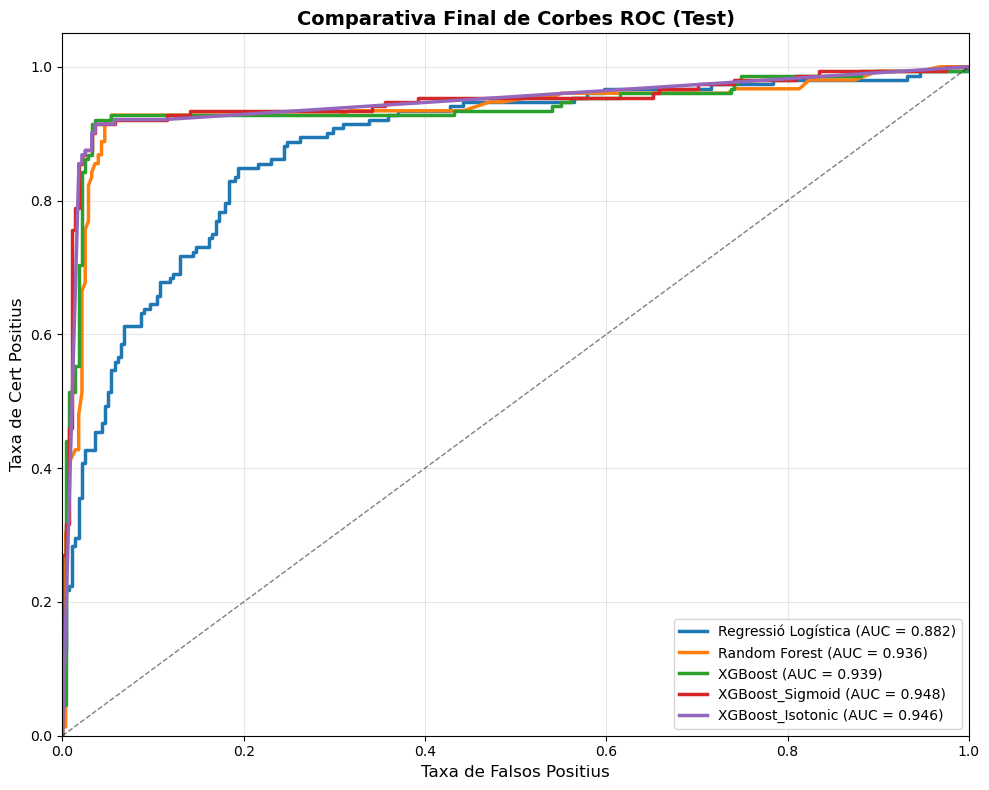

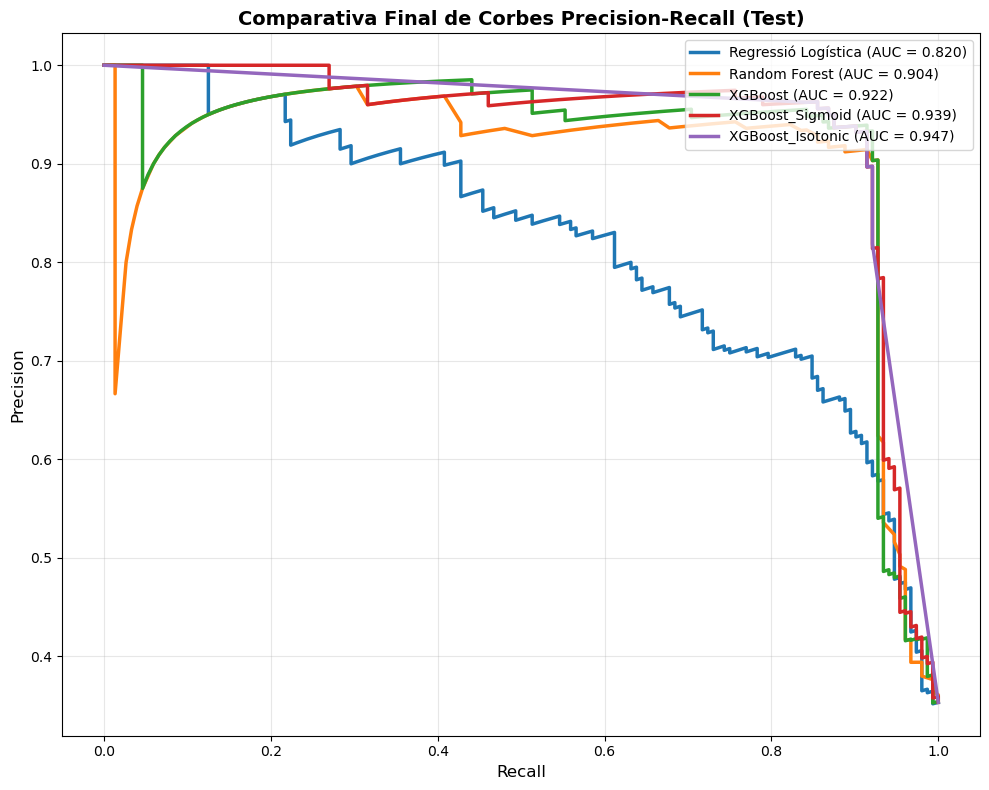

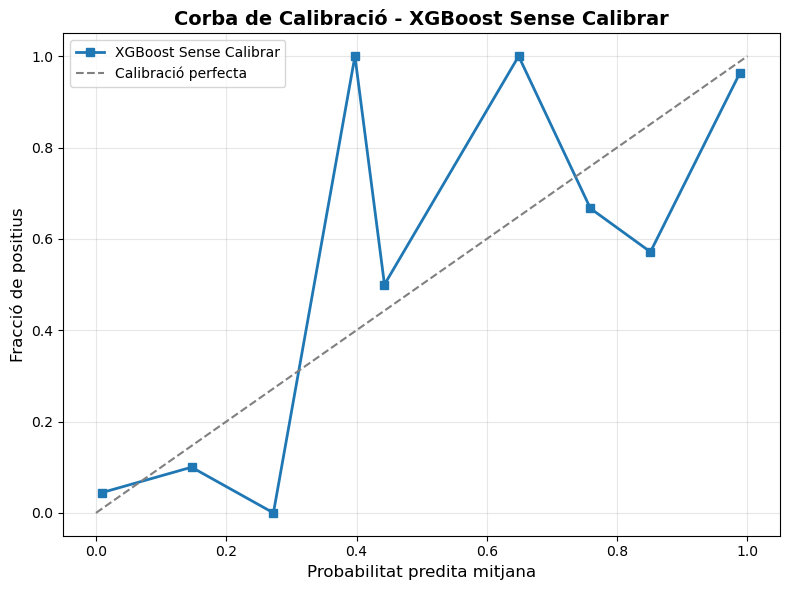

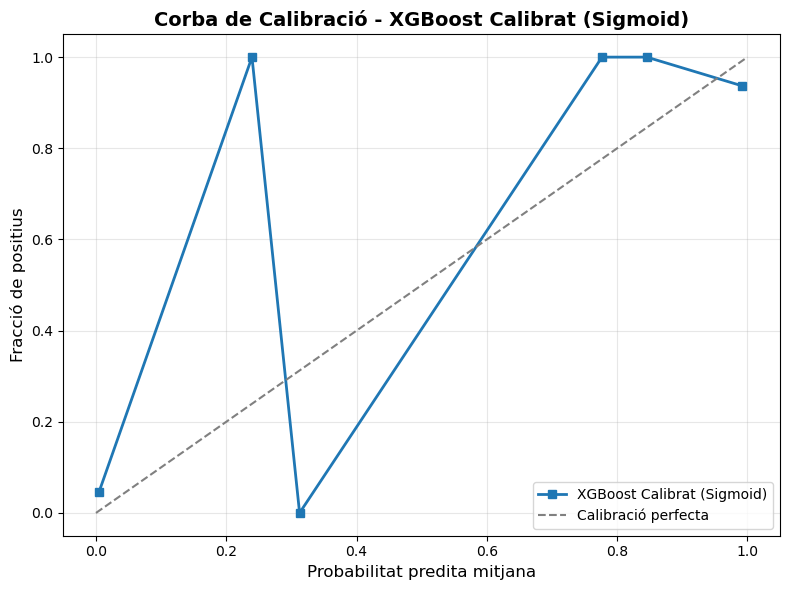

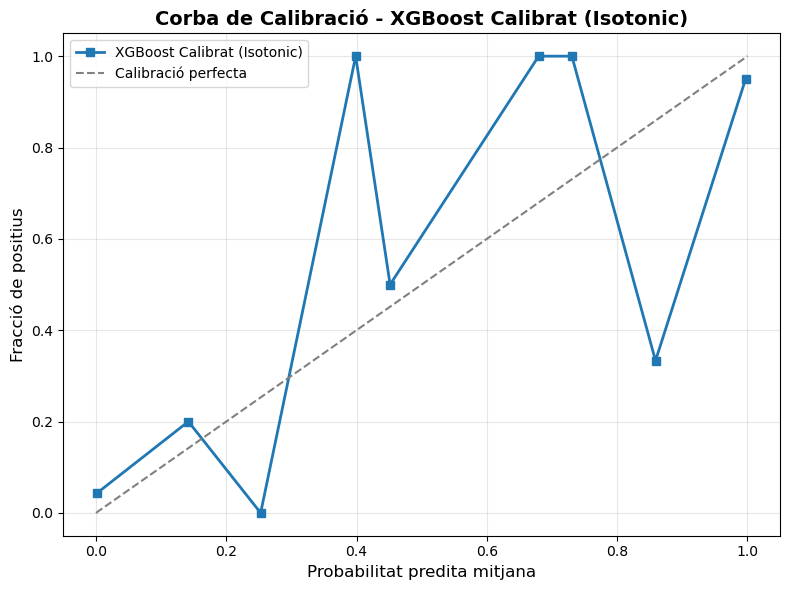

In [22]:
# =============================================================================
# 10. AVALUACIÓ FINAL EN TEST
# =============================================================================

print("\n=== AVALUACIÓ FINAL EN TEST ===")

# Avaluar tots els models en test
results_test = {}

print("Models base:")
for name, model in models.items():
    results_test[name] = evaluate_probs(model, X_test, y_test, prefix=f"{name}_test")

print("\nModels calibrats:")
results_test['XGBoost_Sigmoid'] = evaluate_probs(calibrator_sigmoid, X_test, y_test, prefix="XGB_Sigmoid_test")
results_test['XGBoost_Isotonic'] = evaluate_probs(calibrator_iso, X_test, y_test, prefix="XGB_Iso_test")

# Visualitzacions finals
plot_roc_curves(results_test, y_test, "Comparativa Final de Corbes ROC (Test)")
plot_pr_curves(results_test, y_test, "Comparativa Final de Corbes Precision-Recall (Test)")

# Corbes de calibració
plot_calibration_curve(pipe_xgb_full, X_test, y_test, "XGBoost Sense Calibrar")
plot_calibration_curve(calibrator_sigmoid, X_test, y_test, "XGBoost Calibrat (Sigmoid)")
plot_calibration_curve(calibrator_iso, X_test, y_test, "XGBoost Calibrat (Isotonic)")



In [23]:
# =============================================================================
# 11. ANÀLISI DE RESULTATS I GUARDAT
# =============================================================================

print("\n=== RESULTATS FINALS I GUARDAT ===")

# Resultats del millor model
y_pred_best = calibrator_sigmoid.predict(X_test)
y_proba_best = calibrator_sigmoid.predict_proba(X_test)[:, 1]

accuracy = (y_pred_best == y_test).mean()
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print("MÈTRIQUES FINALS DEL MILLOR MODEL (XGBoost Calibrat - Sigmoid):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {results_test['XGBoost_Sigmoid']['roc_auc']:.4f}")
print(f"PR-AUC: {results_test['XGBoost_Sigmoid']['pr_auc']:.4f}")
print(f"Brier Score: {results_test['XGBoost_Sigmoid']['brier']:.4f}")

print("\nMATRIU DE CONFUSIÓ:")
print(confusion_matrix(y_test, y_pred_best))

print("\nINFORME DE CLASSIFICACIÓ:")
print(classification_report(y_test, y_pred_best))

# Guardar models
joblib.dump(pipe_xgb_full, MODELS / "xgb_base.joblib")
joblib.dump(calibrator_sigmoid, MODELS / "xgb_calibrated_sigmoid.joblib")
joblib.dump(calibrator_iso, MODELS / "xgb_calibrated_isotonic.joblib")

# Guardar mètriques
final_metrics = {
    "millor_model": "XGBoost_Calibrat_Sigmoid",
    "metrics": {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'roc_auc': float(results_test['XGBoost_Sigmoid']['roc_auc']),
        'pr_auc': float(results_test['XGBoost_Sigmoid']['pr_auc']),
        'brier_score': float(results_test['XGBoost_Sigmoid']['brier'])
    },
    "data_info": {
        'total_samples': len(df_clean),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'prevalence': float(y.mean())
    }
}

with open(MODELS / "metrics_finals.json", "w", encoding='utf-8') as f:
    json.dump(final_metrics, f, indent=2, ensure_ascii=False)

print(f"\nModels i mètriques guardats a la carpeta '{MODELS}'")
print("=== ANÀLISI COMPLETAT ===")


=== RESULTATS FINALS I GUARDAT ===
MÈTRIQUES FINALS DEL MILLOR MODEL (XGBoost Calibrat - Sigmoid):
Accuracy: 0.9442
Precision: 0.9384
Recall: 0.9013
F1-score: 0.9195
ROC-AUC: 0.9476
PR-AUC: 0.9392
Brier Score: 0.0533

MATRIU DE CONFUSIÓ:
[[269   9]
 [ 15 137]]

INFORME DE CLASSIFICACIÓ:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.94      0.90      0.92       152

    accuracy                           0.94       430
   macro avg       0.94      0.93      0.94       430
weighted avg       0.94      0.94      0.94       430


Models i mètriques guardats a la carpeta 'models'
=== ANÀLISI COMPLETAT ===
